# Loading and Preprocessing the data

In [49]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras import regularizers, optimizers
from keras.applications import densenet
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy
from keras.models import Model

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download paultimothymooney/kermany2018


In [4]:
!unzip -qq 'kermany2018.zip'

In [71]:

train = tf.keras.utils.image_dataset_from_directory(
    'OCT2017 /train',
    labels='inferred' ,
    label_mode = 'categorical',
    color_mode="rgb",
    batch_size=64,
    image_size=(224, 224),
    shuffle=True,
    seed= 10,
    validation_split=0.1,
    subset='training',
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

val = tf.keras.utils.image_dataset_from_directory(
    'OCT2017 /train',
    labels='inferred' ,
    label_mode = 'categorical',
    color_mode="rgb",
    batch_size=64,
    image_size=(224, 224),
    shuffle=True,
    seed=10,
    validation_split=0.1,
    subset='validation',
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

test = tf.keras.utils.image_dataset_from_directory(
    'OCT2017 /test',
    labels='inferred' ,
    label_mode = 'categorical',
    color_mode="rgb",
    batch_size=1,
    image_size=(224, 224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 83484 files belonging to 4 classes.
Using 75136 files for training.
Found 83484 files belonging to 4 classes.
Using 8348 files for validation.
Found 968 files belonging to 4 classes.


In [72]:
aug = tf.keras.Sequential([
  layers.RandomRotation(factor=(-0.2, 0.3)),
  layers.Rescaling(1./255),
  layers.RandomFlip()
])
aug_2 = layers.Rescaling(1./255)

train = train.map(lambda x, y: (aug(x), y))
val = val.map(lambda x, y: (aug_2(x), y)) 
test = test.map(lambda x, y: (aug_2(x), y))

# Initializing the Network

In [57]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=3, activation='relu', kernel_regularizer=regularizers.l2(1e-4), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=3, activation='relu', kernel_regularizer=regularizers.l2(1e-4), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=regularizers.l2(1e-4), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=regularizers.l2(1e-4), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters=256, kernel_size=3, activation='relu', kernel_regularizer=regularizers.l2(1e-4), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=3, activation='relu', kernel_regularizer=regularizers.l2(1e-4), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters=512, kernel_size=3, activation='relu', kernel_regularizer=regularizers.l2(1e-4), padding='same'))
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(4, activation='softmax'))

In [73]:
model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

from keras.callbacks import ModelCheckpoint , EarlyStopping, ReduceLROnPlateau

checkpointer = ModelCheckpoint(filepath='model.hdf5', save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0.0,
                               patience=3,
                               verbose=1)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.2,
                                         patience=1,
                                         verbose=1,
                                         min_delta=0.001,
                                         cooldown=0,
                                         min_lr=0.00001)
callbacks = [checkpointer ,
             early_stopping,
             reduce_learning_rate]

# Training the Network

In [75]:
history = model.fit(train, validation_data=val, epochs=10, batch_size = 64, verbose=1, callbacks=[callbacks])

Epoch 1/10
1174/1174 [==============================] - 734s 624ms/step - loss: 0.3211 - accuracy: 0.9010 - val_loss: 0.8755 - val_accuracy: 0.7367 - lr: 0.0010
Epoch 2/10
1174/1174 [==============================] - 700s 595ms/step - loss: 0.2463 - accuracy: 0.9290 - val_loss: 0.4931 - val_accuracy: 0.8547 - lr: 0.0010
Epoch 3/10
1174/1174 [==============================] - 700s 595ms/step - loss: 0.2222 - accuracy: 0.9376 - val_loss: 0.3320 - val_accuracy: 0.9021 - lr: 0.0010
Epoch 4/10
1174/1174 [==============================] - 701s 595ms/step - loss: 0.2113 - accuracy: 0.9421 - val_loss: 0.2087 - val_accuracy: 0.9429 - lr: 0.0010
Epoch 5/10
1174/1174 [==============================] - ETA: 0s - loss: 0.2003 - accuracy: 0.9466
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1174/1174 [==============================] - 738s 627ms/step - loss: 0.2003 - accuracy: 0.9466 - val_loss: 0.2273 - val_accuracy: 0.9425 - lr: 0.0010
Epoch 6/10
1174/1174 [=========

# Performance Evaluation

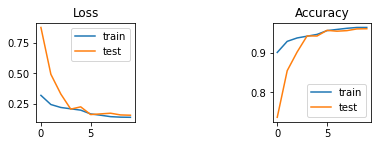

In [76]:
import matplotlib.pyplot as plt

plt.subplot(231)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

plt.subplot(233)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [78]:
x = model.evaluate(test)

968/968 [==============================] - 8s 9ms/step - loss: 0.0625 - accuracy: 0.9897
